# Notebook with task driven pre-trained core

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import MEI
import matplotlib as mpl
from datetime import date
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#Helper fucntion to save text file with log information of the training stage
def save_training_log(info, model_name, path):
    with open(join(path,"Train_log_"+model_name+".txt"), "a") as log_file:
        log_file.write(info)

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test.

In [ ]:
#Dataset directory
path_dataset = [r'C:\Users\inoca\Desktop\Intership EMBL\Python docs\Inception_loop\Ephy_data_Cortex\static20210629_train']

In [3]:
#Configure dataloader/s 
from lurz2020.datasets.mouse_loaders import static_loaders

dataset_config = {'paths': path_dataset, 
                  'batch_size': 64, 
                  'seed': 1,
                  'cuda': True,
                  'normalize': True, 
                  'include_eye_position': False,
                  }

dataloaders = static_loaders(**dataset_config)
dat = FileTreeDataset(path_dataset[0], "images", "responses")

### Look at the data

In [5]:
tier = 'train'
dataset_name = '20210402_train_full_size_images'

images, responses = [], []
for data in dataloaders_RGCs[tier][dataset_name]:
    images.append(data[0].squeeze().cpu().data.numpy())
    responses.append(data[1].squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "20210402_train_full_size_images" contains the responses of 2 RGC neurons to 1128 images


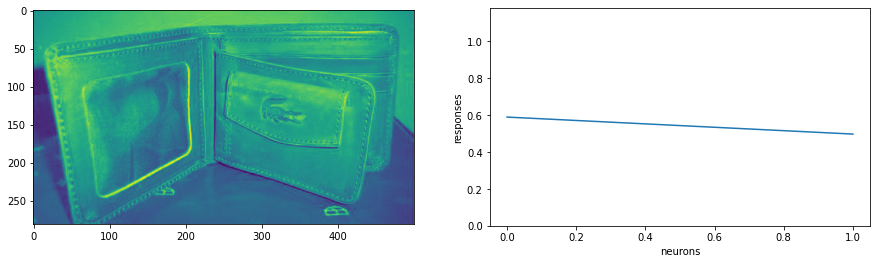

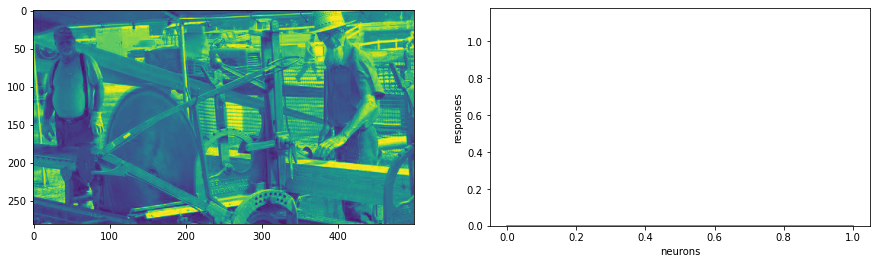

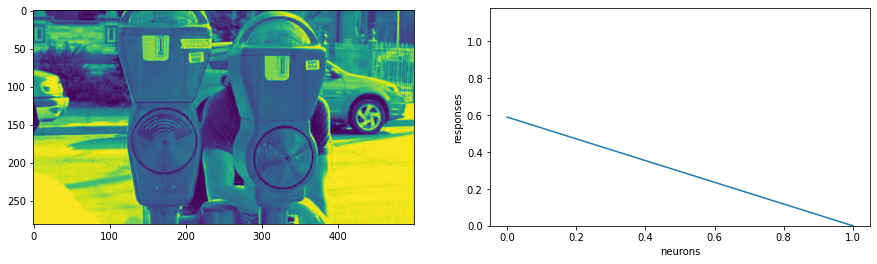

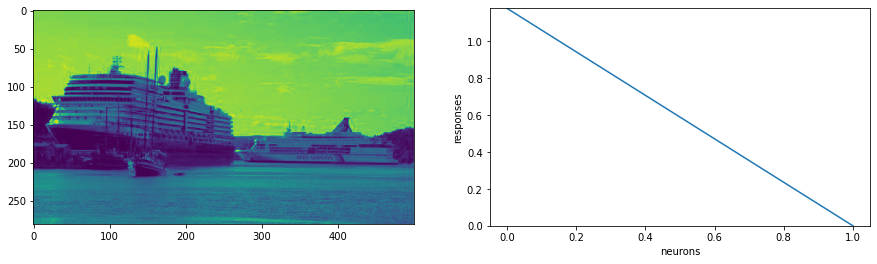

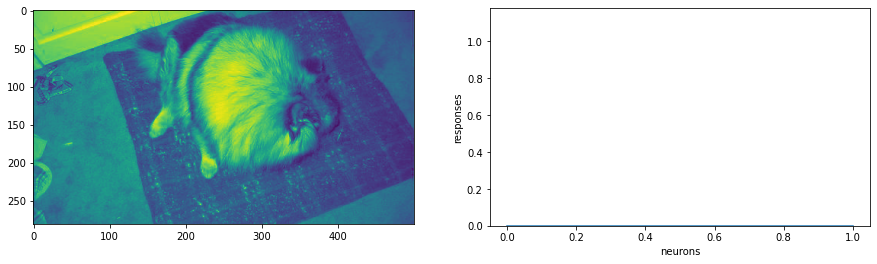

In [6]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model, transfer core, train and evaluate performance - 4 instances

Get 1 instance of the model for MEI generation:

In [7]:
import torchvision as vision

In [50]:
model = vision.models.alexnet(pretrained=True)
list(model.features.children())

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [51]:
%%time 
%%memit
from lurz2020.models.models import taskdriven_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles, get_FEV

#Directory to sava models after training
path_models = join(path_dataset[0], 'models')
os.makedirs(path_models) 

#Models name 
models_name = 'tunned_model_'

#Model config
model_config = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'tl_model_name': "alexnet",
                'layers': 11,
                'pretrained': True,
                'final_batchnorm': False,
                'final_nonlinearity': False,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}


#Change trainer config to not track and print the training progress
trainer_config = {'track_training': True,
                  'detach_core': False}

#Save information of the training stage
comment = "Comment: Results for tunned fullgaussian model with V1 core and readout trained with ephy data with only 3 neurons with possible spatial rf in the visual field, recorded in the cortex." 
date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
stim = "Stimuli dataset: " + dataset_name
model_config = "Model configuration: " + str(model_config_tunned)
log_info = comment+'\n\n'+date+'\n'+ stim+'\n'+model_config+'\n'

save_training_log(log_info, models_name, path_models)

model = taskdriven_fullgaussian2d(**model_config, dataloaders=dataloaders_RGCs, seed=i)
#Run training
model_state_bef = model.state_dict()
model.eval()
score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
model_state_aft = model.state_dict()

#Get performance of model
train_correlation_models = get_correlations(model, dataloaders_RGCs["train"], device='cuda', as_dict=False, per_neuron=False)
validation_correlation_models = get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False)
test_correlation_models = get_correlations(model, dataloaders_RGCs["test"], device='cuda', as_dict=False, per_neuron=False)
    
oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
fraction_oracle.append(get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0])
exp_var_models.append(get_FEV(model, oracle_dataloader, device='cuda', as_dict=False, per_neuron=False, threshold=None))

instance_results = '\n ----------------------------------------- \n \
#Model instance #{0:1d} \n \
#Correlation (train set):      {1:.3f} \n \
#Correlation (validation set): {2:.3f} \n \
#Correlation (test set):       {3:.3f} \n \
#----------------------------------------- \n \
#Fraction oracle (test set):   {4:.3f} \n \
#FEV (test set): {5:.3f}  \n'.format(i, train_correlation_models[i], validation_correlation_models[i],
#                                     test_correlation_models[i], fraction_oracle[i], exp_var_models[i])

#Print and save instance training data on train log file                                     
print(instance_results)
log_info = "\n Model instances training results: \n"+ instance_results
save_training_log(log_info, models_name, path_models)

#Save model state for loading later                                     
models.append(model)
torch.save(model_state, join(path_models,models_name+'.pth'))

correlation -0.0035954094
poisson_loss 105004.59


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:11<00:00, 15.68it/s]


[001|00/05] ---> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:11<00:00, 15.64it/s]


[002|01/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.59it/s]


[003|02/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.43it/s]


[004|03/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.81it/s]


[005|04/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.53it/s]


[006|05/05] -/-> 0.0
Restoring best model after lr decay! 0.000000 ---> 0.000000
correlation 0.0
poisson_loss 115515.52


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 16.92it/s]


Epoch     7: reducing learning rate of group 0 to 1.5000e-03.
[007|01/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:09<00:00, 18.06it/s]


[008|02/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.22it/s]


[009|03/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.23it/s]


[010|04/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:11<00:00, 16.02it/s]


[011|05/05] -/-> 0.0
Restoring best model after lr decay! 0.000000 ---> 0.000000
correlation 0.0
poisson_loss 115515.52


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:11<00:00, 16.11it/s]


[012|01/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.25it/s]


Epoch    13: reducing learning rate of group 0 to 4.5000e-04.
[013|02/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.24it/s]


[014|03/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.46it/s]


[015|04/05] -/-> 0.0
correlation 0.0
poisson_loss 115515.52


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:10<00:00, 17.58it/s]


[016|05/05] -/-> 0.0
Restoring best model after lr decay! 0.000000 ---> 0.000000
Restoring best model! 0.000000 ---> 0.000000


IndexError: invalid index to scalar variable.

### Predict neural responses to an image (here from the train set)

In [ ]:
# show some example images and the neural responses
n_images = 10
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

-------------------

In [ ]:
torch.cuda.empty_cache()

-----------------------------